In [100]:
from sklearn.datasets import load_files
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from keras.utils import np_utils, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D
from keras.layers import Activation, Dense, Flatten, Dropout, Reshape
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.models import load_model
import h5py

In [101]:
import tensorflow as tf
print("Available GPUs:")
print(tf.config.list_physical_devices("GPU"))

# GPU visibility setting
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')

# Setting the computation mode to the GPU
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Available GPUs:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [102]:
train_dir = '../fruit recognition/dataset/train'
test_dir = '../fruit recognition/dataset/test'
val_dir = '../fruit recognition/dataset/validation'

def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels
    
x_train, y_train,target_labels = load_dataset(train_dir)
x_test, y_test,_ = load_dataset(test_dir)
x_val, y_val,_ = load_dataset(val_dir)
print('Loading complete!')

print('Training set size : ' , x_train.shape[0])
print('Testing set size : ', x_test.shape[0])
print('Testing set size : ', x_val.shape[0])

Loading complete!
Training set size :  3115
Testing set size :  347
Testing set size :  351


In [103]:
# number of classes
no_of_classes = len(np.unique(y_train))
no_of_classes

34

In [104]:
y_train = np_utils.to_categorical(y_train,no_of_classes)
y_test = np_utils.to_categorical(y_test,no_of_classes)
y_val = np_utils.to_categorical(y_val,no_of_classes)
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [105]:
def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
        img = load_img(file)
        img = img.resize((224, 224))
        image_array = img_to_array(img)
        images_as_array.append(image_array)
    return images_as_array

x_train = np.array(convert_image_to_array(x_train))
print('Training set shape : ',x_train.shape)

x_val = np.array(convert_image_to_array(x_val))
print('Validation set shape : ',x_val.shape)

x_test = np.array(convert_image_to_array(x_test))
print('Test set shape : ',x_test.shape)

print('1st training image shape ',x_train[0].shape)

e:\pycharmik\fruit recognition\.venv\lib\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training set shape :  (3115, 224, 224, 3)
Validation set shape :  (351, 224, 224, 3)
Test set shape :  (347, 224, 224, 3)
1st training image shape  (224, 224, 3)


In [106]:
# rescale to values within 0 to 1
x_train = x_train.astype('float32')/255
x_val = x_val.astype('float32')/255
x_test = x_test.astype('float32')/255
x_train[0]

array([[[0.84313726, 0.627451  , 0.38431373],
        [0.8       , 0.6       , 0.37254903],
        [0.7176471 , 0.5411765 , 0.32941177],
        ...,
        [0.99607843, 0.8235294 , 0.29411766],
        [0.99607843, 0.8235294 , 0.29411766],
        [0.99607843, 0.8235294 , 0.29411766]],

       [[0.84313726, 0.627451  , 0.38431373],
        [0.8       , 0.6       , 0.37254903],
        [0.72156864, 0.54901963, 0.3254902 ],
        ...,
        [0.9882353 , 0.8117647 , 0.2901961 ],
        [0.9882353 , 0.8156863 , 0.2901961 ],
        [0.9882353 , 0.8156863 , 0.2901961 ]],

       [[0.85490197, 0.63529414, 0.39607844],
        [0.8117647 , 0.61960787, 0.37254903],
        [0.7607843 , 0.5882353 , 0.32941177],
        ...,
        [0.972549  , 0.7882353 , 0.2784314 ],
        [0.9843137 , 0.79607844, 0.2784314 ],
        [0.9882353 , 0.8       , 0.28235295]],

       ...,

       [[1.        , 0.8666667 , 0.4       ],
        [1.        , 0.87058824, 0.38431373],
        [1.        , 0

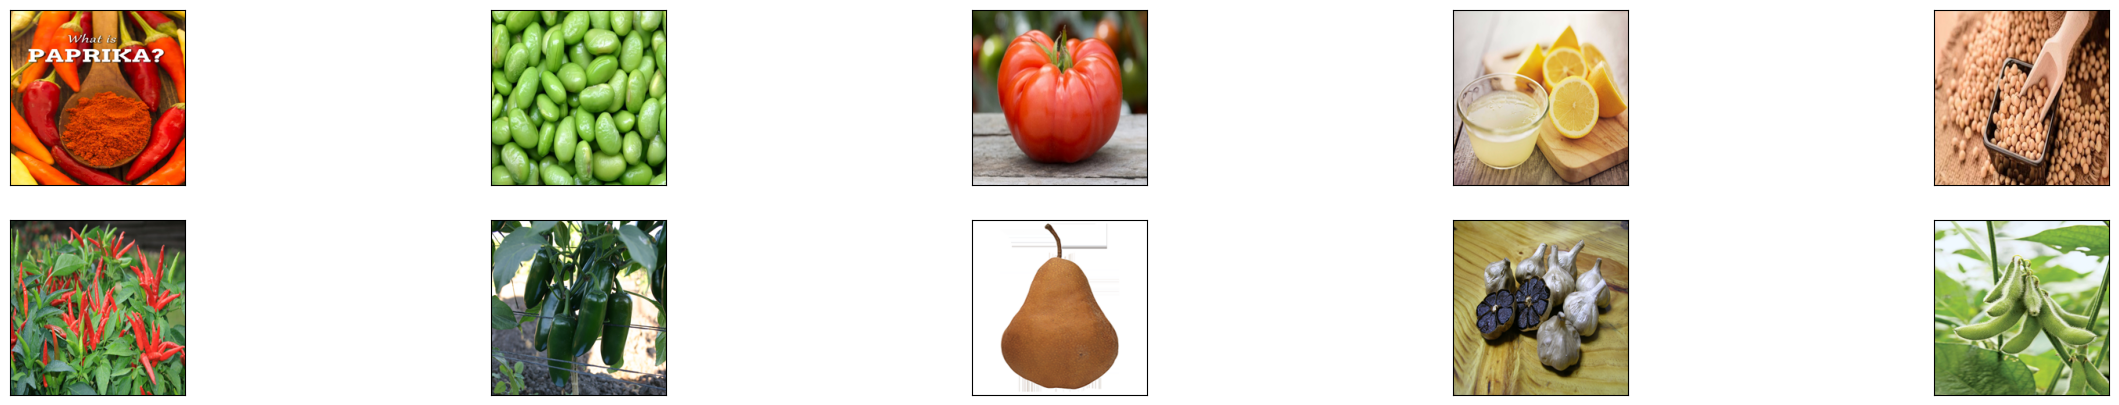

In [107]:
# Visualize first 10 images
fig = plt.figure(figsize =(30,5))
for i in range(10):
    ax = fig.add_subplot(2,5,i+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(x_train[i]))

In [108]:
# augmentation
datagen = ImageDataGenerator(
    rotation_range=20,  # zakres losowego obracania obrazu (w stopniach)
    width_shift_range=0.2,  # zakres losowego przesunięcia obrazu w poziomie
    height_shift_range=0.2,  # zakres losowego przesunięcia obrazu w pionie
    shear_range=0.2,  # zakres skręcenia obrazu
    zoom_range=0.2,  # zakres losowego przybliżenia obrazu
    horizontal_flip=True,  # losowe odbicie lustrzane w poziomie
    vertical_flip=True  # losowe odbicie lustrzane w pionie
)

# Dopasowanie generatora danych do danych treningowych
datagen.fit(x_train)

# Generowanie dodatkowych obrazów dla danych treningowych
augmented_train_data = datagen.flow(x_train, y_train, batch_size=len(x_train), shuffle=False)

# Pobranie wygenerowanych obrazów i etykiet
x_train_augmented, y_train_augmented = augmented_train_data.next()

# Wyświetlenie rozmiaru nowych danych treningowych
print('Augmented training set size: ', x_train_augmented.shape[0])

# Generowanie dodatkowych obrazów dla danych walidacyjnych
augmented_val_data = datagen.flow(x_val, y_val, batch_size=len(x_val), shuffle=False)

# Pobranie wygenerowanych obrazów i etykiet
x_val_augmented, y_val_augmented = augmented_val_data.next()

# Wyświetlenie rozmiaru nowych danych walidacyjnych
print('Augmented validation set size: ', x_val_augmented.shape[0])


Augmented training set size:  3115
Augmented validation set size:  351


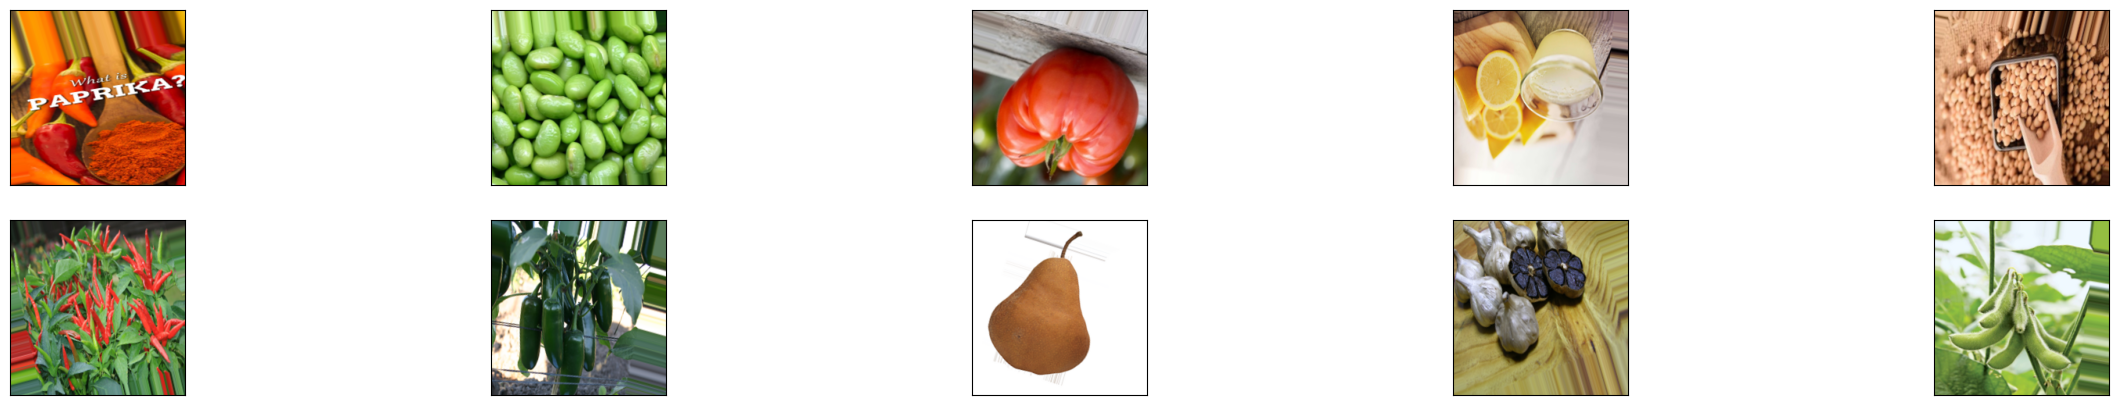

In [109]:
# Visualize first 10 images with augmentation
fig = plt.figure(figsize =(30,5))
for i in range(10):
    ax = fig.add_subplot(2,5,i+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(x_train_augmented[i]))

In [110]:
# Augmented data blending
x_train_combined = np.concatenate((x_train, x_train_augmented), axis=0)
y_train_combined = np.concatenate((y_train, y_train_augmented), axis=0)

x_val_combined = np.concatenate((x_val, x_val_augmented), axis=0)
y_val_combined = np.concatenate((y_val, y_val_augmented), axis=0)
print('combined x_train set size: ', x_train_combined.shape)
print('combined y_train set size: ', y_train_combined.shape)

print('combined x_val set size: ', x_val_combined.shape)
print('combined y_val set size: ', y_val_combined.shape)

combined x_train set size:  (6230, 224, 224, 3)
combined y_train set size:  (6230, 34)
combined x_val set size:  (702, 224, 224, 3)
combined y_val set size:  (702, 34)


In [111]:
# Create model with 3 Conv layers with maxpooling. Added dropout, flatten.
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(224, 224, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(34, activation='softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer = 'adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 224, 224, 16)      208       
                                                                 
 activation_3 (Activation)   (None, 224, 224, 16)      0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 111, 111, 32)      2080      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 55, 55, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 54, 54, 64)       

In [112]:
# manually convert data to tf tensors (save time)
with tf.device('/cpu:0'):
   x_train_combined = tf.convert_to_tensor(x_train_combined, np.float32)
   y_train_combined = tf.convert_to_tensor(y_train_combined, np.float32)
   x_val_combined = tf.convert_to_tensor(x_val_combined, np.float32)
   y_val_combined = tf.convert_to_tensor(y_val_combined, np.float32)
   x_test = tf.convert_to_tensor(x_test, np.float32)
   y_test = tf.convert_to_tensor(y_test, np.float32)

In [115]:
history = model.fit(x_train_combined,
                    y_train_combined,
                    batch_size = 16,
                    epochs = 20,
                    validation_data = (x_val_combined, y_val_combined)
                    )

Epoch 1/10
390/390 [==============================] - 10s 26ms/step - loss: 0.2072 - accuracy: 0.9310 - val_loss: 1.3112 - val_accuracy: 0.7336
Epoch 2/10
390/390 [==============================] - 10s 26ms/step - loss: 0.2103 - accuracy: 0.9348 - val_loss: 1.1503 - val_accuracy: 0.7564
Epoch 3/10
390/390 [==============================] - 10s 27ms/step - loss: 0.1905 - accuracy: 0.9345 - val_loss: 1.3056 - val_accuracy: 0.7436
Epoch 4/10
390/390 [==============================] - 10s 26ms/step - loss: 0.1883 - accuracy: 0.9396 - val_loss: 1.3535 - val_accuracy: 0.7464
Epoch 5/10
390/390 [==============================] - 10s 26ms/step - loss: 0.1977 - accuracy: 0.9329 - val_loss: 1.2536 - val_accuracy: 0.7393
Epoch 6/10
390/390 [==============================] - 10s 26ms/step - loss: 0.1696 - accuracy: 0.9464 - val_loss: 1.3144 - val_accuracy: 0.7365
Epoch 7/10
390/390 [==============================] - 10s 26ms/step - loss: 0.1861 - accuracy: 0.9398 - val_loss: 1.2827 - val_accuracy:

In [116]:
result = model.evaluate(x_test, y_test, verbose=0)
print('\nTest loss:', round(result[0], 4))
print('\nTest accuracy:', round(result[1], 4))


Test loss: 0.2804

Test accuracy: 0.9625


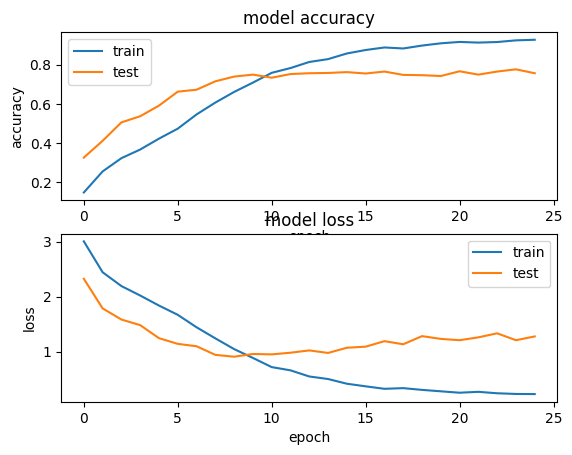

In [92]:
plt.figure(1)  
# summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'])  
   
# summarize history for loss  

plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'])  
plt.show()

11/11 [==============================] - 2s 151ms/step


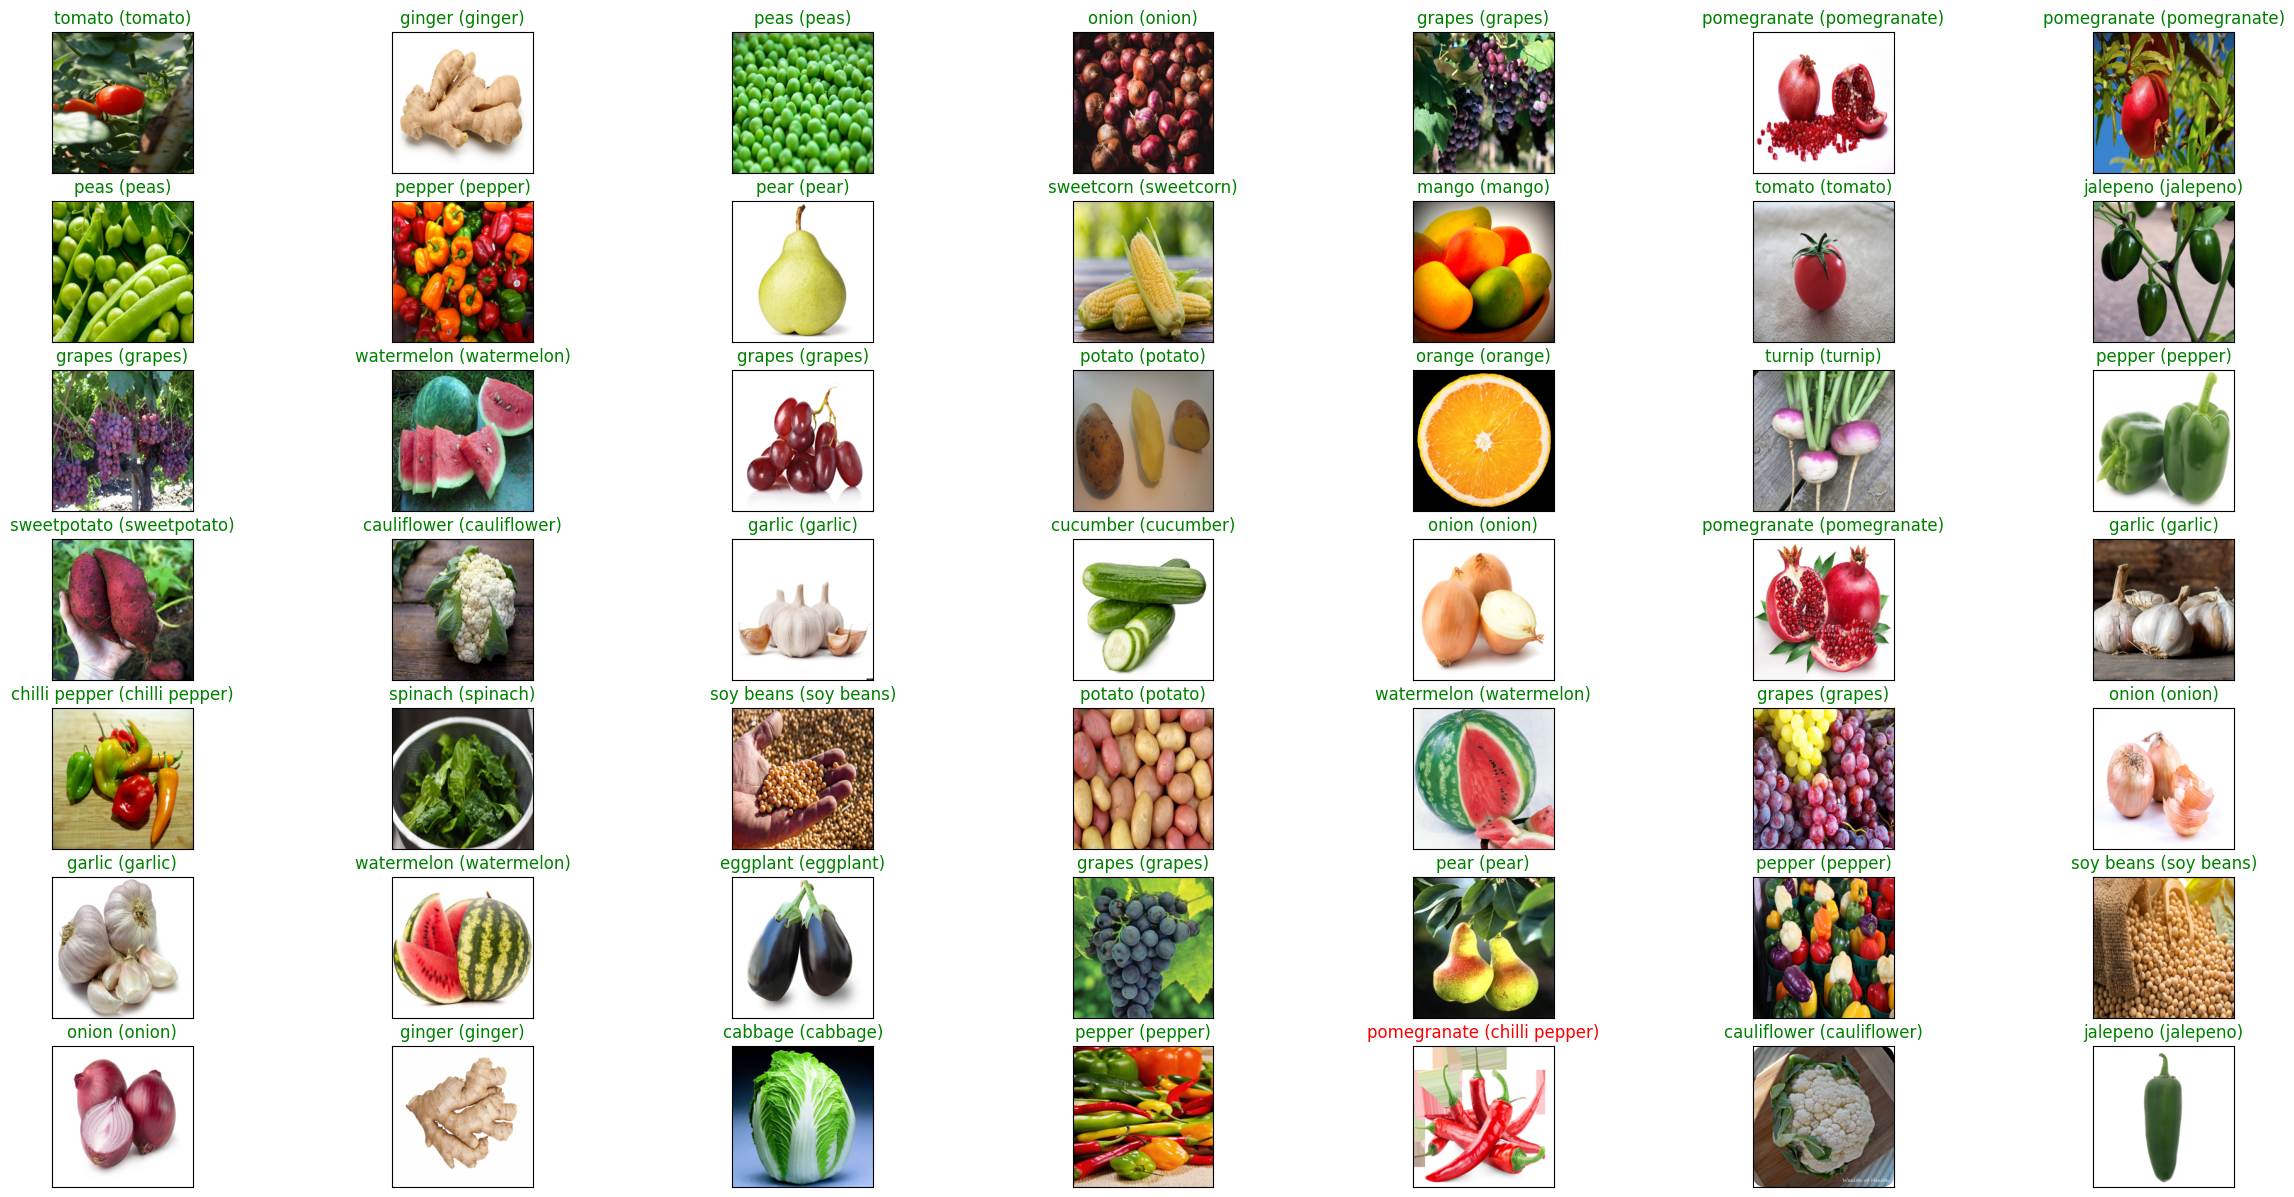

In [93]:
# prediction on test data
with tf.device('/cpu:0'):
    y_pred = model.predict(x_test)


fig = plt.figure(figsize=(30, 15))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=49, replace=False)):
    ax = fig.add_subplot(7, 7, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

In [94]:
images_dir = '../fruit recognition/images'

def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels

def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
        img = load_img(file)
        img = img.resize((224, 224))
        image_array = img_to_array(img)
        images_as_array.append(image_array)
    return images_as_array

_, _,target_labels = load_dataset(images_dir)


x_images, y_images,_ = load_dataset(images_dir)
print('Loading complete!')

print('Images set size : ', x_images.shape[0])
y_images = np_utils.to_categorical(y_images,34)


x_images = np.array(convert_image_to_array(x_images))
print('Test set shape : ',x_images.shape)

print('1st training image shape ',x_images[0].shape)

# rescale to values within 0 to 1
x_images = x_images.astype('float32')/255

Loading complete!
Images set size :  51
Test set shape :  (51, 224, 224, 3)
1st training image shape  (224, 224, 3)


2/2 [==============================] - 0s 97ms/step


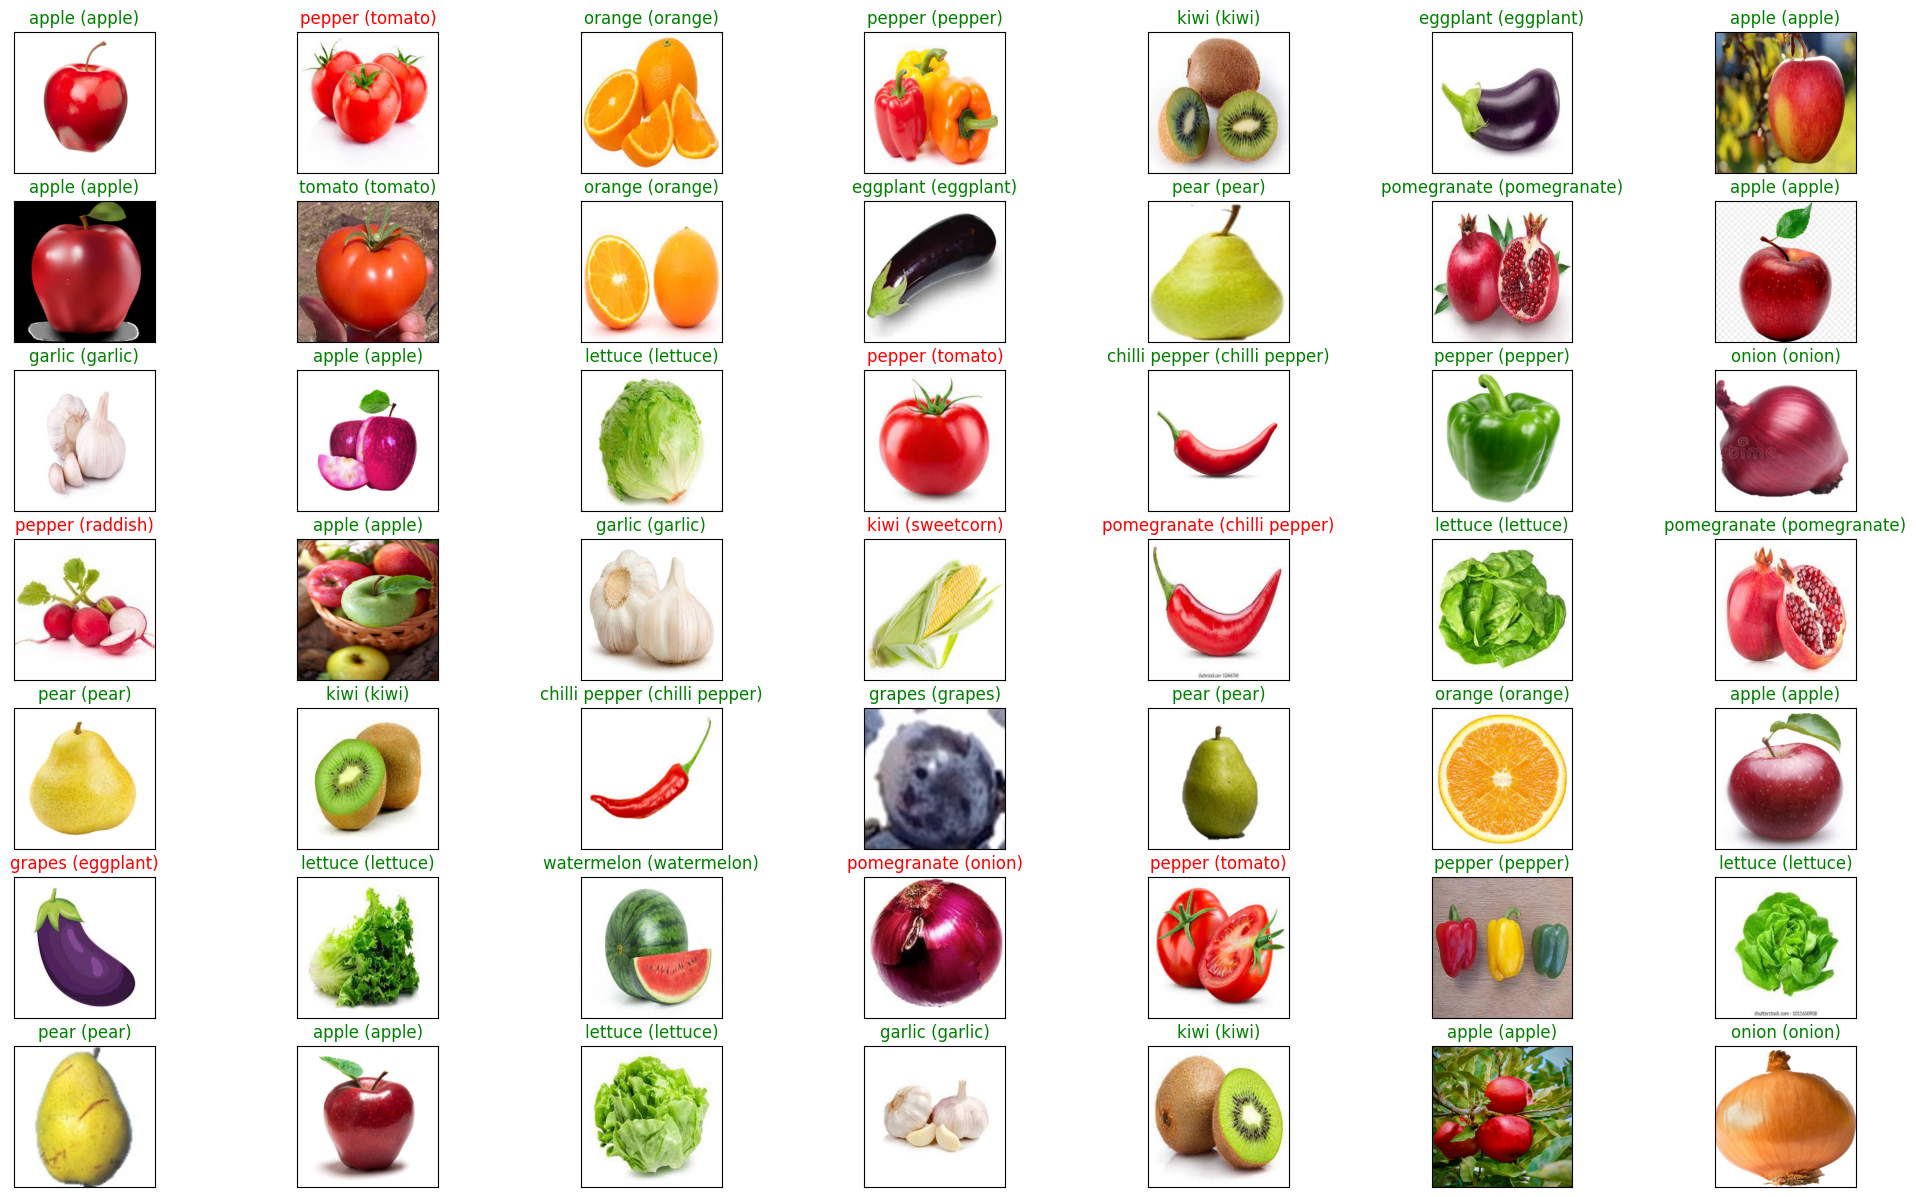

In [95]:
# prediction on test data
with tf.device('/cpu:0'):
    y_pred_images = model.predict(x_images)


fig = plt.figure(figsize=(25, 15))
for i, idx in enumerate(np.random.choice(x_images.shape[0], size=49, replace=False)):
    ax = fig.add_subplot(7, 7, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_images[idx]))
    pred_idx = np.argmax(y_pred_images[idx])
    true_idx = np.argmax(y_images[idx])
    ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

In [96]:
# save trained model with pickle
import pickle
model_pkl_file = "fruit_classifier_model_96.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(model, file)

# save model using tf keras
model.save('fruit_classifier_model_96.h5')

INFO:tensorflow:Assets written to: ram://529ffbcd-7224-46ad-bd6e-168c3b02b4b7/assets


INFO:tensorflow:Assets written to: ram://529ffbcd-7224-46ad-bd6e-168c3b02b4b7/assets


In [97]:
# check saved model
model = load_model('fruit_classifier_model_96.h5', compile=False)
model.compile()
model